<a href="https://colab.research.google.com/github/MengOonLee/AccountReceivable/blob/main/Workflow/InvoicePayment/Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Invoice Payment Forecasting

Accounts Receivables (AR) is an important aspect of businesses, it is a credit extended by the company to the client that require payments due within a time period. With B2B transactions increasing in volume and complexity, poor management of AR can lead to to unnecessary cash flow problems.

Invoice payment forecasting can be used to optimize collection strategies that allows businesses to predict and plan for future customer payments. By analyzing customer payment history, businesses can forecast their future accounts receivable balance and plan accordingly. By identifying invoices that are likely to be paid late, customers who are likely to have large amounts of overdue receivables, which in turn can lead to better visibility into future cash flow.

The invoices dataset contains the past payment information and behaviour of various buyers [here](https://www.kaggle.com/datasets/hhenry/finance-factoring-ibm-late-payment-histories).

The goal is to leverage LLM to forecast time series in a sentence-to-sentence fashion. In order to achieve this goal, the numerical time series values need to be transferred and described as natural language sentences. Specifically, the input numerical sequence $x^m_{t_1:t_{obs}}$ is turned into input prompts, and the forecasting target values are transformed as the output prompt. Consequently, time series forecasting can be addressed through a natural language generation paradigm, and LLM can be adopted as the core forecasting models.

Instruction fine-tuning is a common technique used to fine-tune a base LLM for a specific use-case using own datasets.

In [ ]:
%%bash
pip install --no-cache-dir -qU \
    torch datasets accelerate peft bitsandbytes transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 336.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 267.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 278.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 288.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 257.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 283.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 315.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 322.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 192.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 166.7 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings('ignore')
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# Pre-processing dataset

In [ ]:
import os
import pandas as pd

input_dir = './Data/Input'
input_invoice = 'WA_Fn-UseC_-Accounts-Receivable.csv'
df = pd.read_csv(os.path.join(input_dir, input_invoice))
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   countryCode    2466 non-null   int64  
 1   customerID     2466 non-null   object 
 2   PaperlessDate  2466 non-null   object 
 3   invoiceNumber  2466 non-null   int64  
 4   InvoiceDate    2466 non-null   object 
 5   DueDate        2466 non-null   object 
 6   InvoiceAmount  2466 non-null   float64
 7   Disputed       2466 non-null   object 
 8   SettledDate    2466 non-null   object 
 9   PaperlessBill  2466 non-null   object 
 10  DaysToSettle   2466 non-null   int64  
 11  DaysLate       2466 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 231.3+ KB


,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate
0,391,0379-NEVHP,4/6/2013,611365,1/2/2013,2/1/2013,55.94,No,1/15/2013,Paper,13,0
1,406,8976-AMJEO,3/3/2012,7900770,1/26/2013,2/25/2013,61.74,Yes,3/3/2013,Electronic,36,6
2,391,2820-XGXSB,1/26/2012,9231909,7/3/2013,8/2/2013,65.88,No,7/8/2013,Electronic,5,0
3,406,9322-YCTQO,4/6/2012,9888306,2/10/2013,3/12/2013,105.92,No,3/17/2013,Electronic,35,5
4,818,6627-ELFBK,11/26/2012,15752855,10/25/2012,11/24/2012,72.27,Yes,11/28/2012,Paper,34,4


In [ ]:
import pandas as pd

df_invoice = df.copy()

for c in ['InvoiceDate']:
    df_invoice[c] = pd.to_datetime(df_invoice[c],
        format='%m/%d/%Y').dt.date

df_invoice.sort_values(by=['customerID', 'InvoiceDate'], inplace=True)
df_invoice.drop(columns=['countryCode', 'PaperlessDate', 'invoiceNumber',
    'DueDate', 'Disputed', 'SettledDate', 'PaperlessBill', 'DaysLate'],
    inplace=True)

df_invoice[df_invoice['customerID']=='2621-XCLEH']

,customerID,InvoiceDate,InvoiceAmount,DaysToSettle
1607,2621-XCLEH,2012-01-13,80.99,61
139,2621-XCLEH,2012-02-21,79.51,46
946,2621-XCLEH,2012-02-22,69.80,43
1431,2621-XCLEH,2012-03-02,67.51,57
1404,2621-XCLEH,2012-03-23,89.05,52
2152,2621-XCLEH,2012-04-16,74.06,44
1100,2621-XCLEH,2012-06-27,69.42,60
1882,2621-XCLEH,2012-11-18,86.39,75
1695,2621-XCLEH,2013-03-01,58.96,55
28,2621-XCLEH,2013-03-31,70.93,55


In [ ]:
mask = df_invoice['customerID']=='2621-XCLEH'
sample = df_invoice[mask]
train_sample = sample[:-1]
test_sample = sample[-1:]

prompt = f"""\
Given the dataset delimited by the triple backticks, forecast number of days client \
{test_sample['customerID'].values[0]} will take for the payment of an invoice dated \
{test_sample['InvoiceDate'].values[0]} with an amount \
{test_sample['InvoiceAmount'].values[0]} to be settled.

Return the answer in JSON format, containing four keys: \
'customerID', 'InvoiceDate', 'InvoiceAmount' and 'DaysToSettle'. \
Return only the forecast, not the Python code.

```
{train_sample.to_string(index=False)}
```\
"""

prompt

"Given the dataset delimited by the triple backticks, forecast number of days client 2621-XCLEH will take for the payment of an invoice dated 2013-07-28 with an amount 92.17 to be settled.\n\nReturn the answer in JSON format, containing four keys: 'customerID', 'InvoiceDate', 'InvoiceAmount' and 'DaysToSettle'. Return only the forecast, not the Python code.\n\n```\ncustomerID InvoiceDate  InvoiceAmount  DaysToSettle\n2621-XCLEH  2012-01-13          80.99            61\n2621-XCLEH  2012-02-21          79.51            46\n2621-XCLEH  2012-02-22          69.80            43\n2621-XCLEH  2012-03-02          67.51            57\n2621-XCLEH  2012-03-23          89.05            52\n2621-XCLEH  2012-04-16          74.06            44\n2621-XCLEH  2012-06-27          69.42            60\n2621-XCLEH  2012-11-18          86.39            75\n2621-XCLEH  2013-03-01          58.96            55\n2621-XCLEH  2013-03-31          70.93            55\n2621-XCLEH  2013-04-27          65.76            

### Test on ChatGPT:
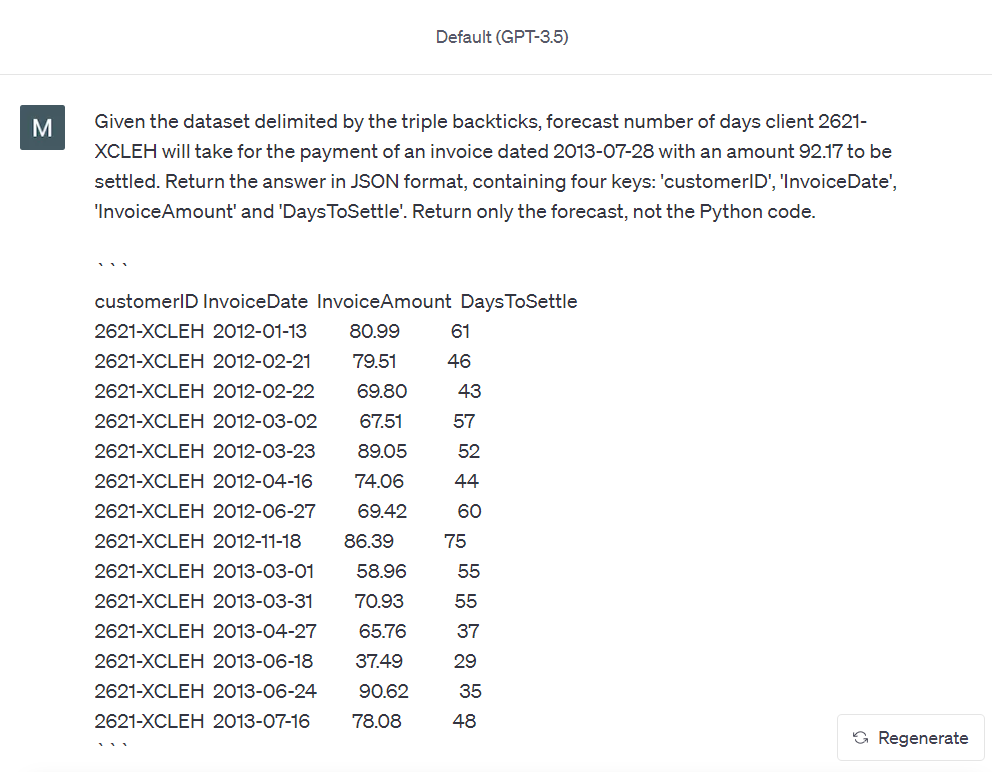

### Response from chatGPT:
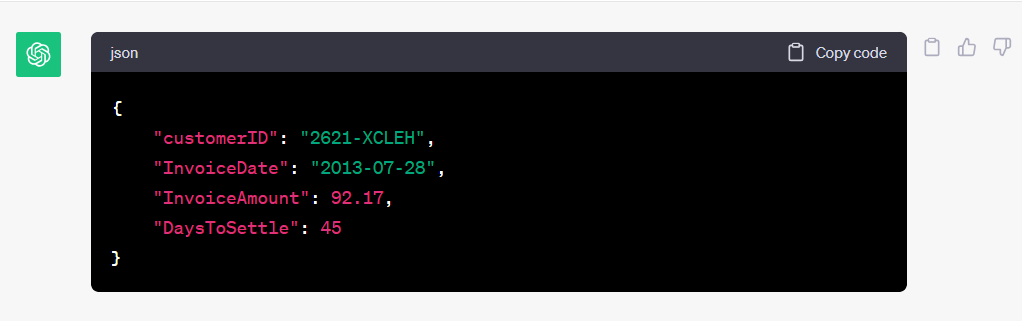

### Create train data

In [ ]:
import os
import pandas as pd

def create_train_df(x):
    d = {}
    d['instruction'] = f"""\
Given the dataset delimited by the triple backticks, forecast number of days \
client {x['customerID'][-2:-1].values[0]} will take for the payment of an \
invoice dated {x['InvoiceDate'][-2:-1].values[0]} with an amount \
{x['InvoiceAmount'][-2:-1].values[0]} to be settled. \
Return the answer in JSON format, containing four keys: \
'customerID', 'InvoiceDate', 'InvoiceAmount' and 'DaysToSettle'. \
Return only the forecast, not the Python code.\
"""
    d['input'] = f"""```
{x[:-2].to_string(index=False)}
```"""
    d['response'] = {
        "customerID":f"{x['customerID'][-2:-1].values[0]}",
        "InvoiceDate":f"{x['InvoiceDate'][-2:-1].values[0]}",
        "InvoiceAmount":x['InvoiceAmount'][-2:-1].values[0],
        "DaysToSettle":x['DaysToSettle'][-2:-1].values[0]
    }

    return pd.Series(d, index=['instruction', 'input', 'response'])

df_train = df_invoice.copy()\
    .sort_values(by=['customerID', 'InvoiceDate'])\
    .groupby('customerID')\
    .apply(create_train_df)\
    .reset_index()\
    .drop(columns=['customerID'])

# Saving as a JSON file
output_dir = './Data/Output'
output_csv = 'train.csv'
df_train.to_csv(os.path.join(output_dir, output_csv), index=False)

display(df_train)

,instruction,input,response
0,Given the dataset delimited by the triple back...,```\ncustomerID InvoiceDate InvoiceAmount Da...,"{'customerID': '0187-ERLSR', 'InvoiceDate': '2..."
1,Given the dataset delimited by the triple back...,```\ncustomerID InvoiceDate InvoiceAmount Da...,"{'customerID': '0379-NEVHP', 'InvoiceDate': '2..."
2,Given the dataset delimited by the triple back...,```\ncustomerID InvoiceDate InvoiceAmount Da...,"{'customerID': '0465-DTULQ', 'InvoiceDate': '2..."
3,Given the dataset delimited by the triple back...,```\ncustomerID InvoiceDate InvoiceAmount Da...,"{'customerID': '0625-TNJFG', 'InvoiceDate': '2..."
4,Given the dataset delimited by the triple back...,```\ncustomerID InvoiceDate InvoiceAmount Da...,"{'customerID': '0688-XNJRO', 'InvoiceDate': '2..."
...,...,...,...
95,Given the dataset delimited by the triple back...,```\ncustomerID InvoiceDate InvoiceAmount Da...,"{'customerID': '9758-AIEIK', 'InvoiceDate': '2..."
96,Given the dataset delimited by the triple back...,```\ncustomerID InvoiceDate InvoiceAmount Da...,"{'customerID': '9771-QTLGZ', 'InvoiceDate': '2..."
97,Given the dataset delimited by the triple back...,```\ncustomerID InvoiceDate InvoiceAmount Da...,"{'customerID': '9841-XLGBV', 'InvoiceDate': '2..."
98,Given the dataset delimited by the triple back...,```\ncustomerID InvoiceDate InvoiceAmount Da...,"{'customerID': '9883-SDWFS', 'InvoiceDate': '2..."


### Create test data

In [ ]:
import os
import pandas as pd

def create_test_df(x):
    d = {}
    d['instruction'] = f"""\
Given the dataset delimited by the triple backticks, forecast number of days \
client {x['customerID'][-1:].values[0]} will take for the payment of an \
invoice dated {x['InvoiceDate'][-1:].values[0]} with an amount \
{x['InvoiceAmount'][-1:].values[0]} to be settled. \
Return the answer in JSON format, containing four keys: \
'customerID', 'InvoiceDate', 'InvoiceAmount' and 'DaysToSettle'. \
Return only the forecast, not the Python code.\
"""
    d['input'] = f"""```
{x[:-1].to_string(index=False)}
```"""
    d['response'] = {
        "customerID":f"{x['customerID'][-1:].values[0]}",
        "InvoiceDate":f"{x['InvoiceDate'][-1:].values[0]}",
        "InvoiceAmount":x['InvoiceAmount'][-1:].values[0],
        "DaysToSettle":x['DaysToSettle'][-1:].values[0]
    }

    return pd.Series(d, index=['instruction', 'input', 'response'])

df_test = df_invoice.copy()\
    .sort_values(by=['customerID', 'InvoiceDate'])\
    .groupby('customerID')\
    .apply(create_test_df)\
    .reset_index()\
    .drop(columns=['customerID'])

output_dir = './Data/Output'
output_csv = 'test.csv'
df_test.to_csv(os.path.join(output_dir, output_csv), index=False)

display(df_test)

,instruction,input,response
0,Given the dataset delimited by the triple back...,```\ncustomerID InvoiceDate InvoiceAmount Da...,"{'customerID': '0187-ERLSR', 'InvoiceDate': '2..."
1,Given the dataset delimited by the triple back...,```\ncustomerID InvoiceDate InvoiceAmount Da...,"{'customerID': '0379-NEVHP', 'InvoiceDate': '2..."
2,Given the dataset delimited by the triple back...,```\ncustomerID InvoiceDate InvoiceAmount Da...,"{'customerID': '0465-DTULQ', 'InvoiceDate': '2..."
3,Given the dataset delimited by the triple back...,```\ncustomerID InvoiceDate InvoiceAmount Da...,"{'customerID': '0625-TNJFG', 'InvoiceDate': '2..."
4,Given the dataset delimited by the triple back...,```\ncustomerID InvoiceDate InvoiceAmount Da...,"{'customerID': '0688-XNJRO', 'InvoiceDate': '2..."
...,...,...,...
95,Given the dataset delimited by the triple back...,```\ncustomerID InvoiceDate InvoiceAmount Da...,"{'customerID': '9758-AIEIK', 'InvoiceDate': '2..."
96,Given the dataset delimited by the triple back...,```\ncustomerID InvoiceDate InvoiceAmount Da...,"{'customerID': '9771-QTLGZ', 'InvoiceDate': '2..."
97,Given the dataset delimited by the triple back...,```\ncustomerID InvoiceDate InvoiceAmount Da...,"{'customerID': '9841-XLGBV', 'InvoiceDate': '2..."
98,Given the dataset delimited by the triple back...,```\ncustomerID InvoiceDate InvoiceAmount Da...,"{'customerID': '9883-SDWFS', 'InvoiceDate': '2..."


### Download LLaMA 2 model
As mentioned before, LLaMA 2 models come in different flavors which are 7B, 13B, and 70B. Your choice can be influenced by your computational resources. Indeed, larger models require more resources, memory, processing power, and training time.

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' cr

In [ ]:
import transformers

def load_model(model_name, bnb_config):
    n_gpus = torch.cuda.device_count()
    max_memory = f'{40960}MB'

    model = transformers.AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto",
        max_memory = {i: max_memory for i in range(n_gpus)},
    )
    tokenizer = transformers.AutoTokenizer.from_pretrained(
        model_name, use_auth_token=True)

    tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

### Create bnb config

This will allow us to load our LLM in 4 bits. This way, we can divide the used memory by 4 and import the model on smaller devices. We choose to apply bfloat16 compute data type and nested quantization for memory-saving purposes.

In [ ]:
import torch
import transformers

def create_bnb_config():
    bnb_config = transformers.BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )

    return bnb_config

Finally, we will call the above functions to get `model` and `tokenizer` objects.

In [ ]:
# The pre-trained model from the Hugging Face Hub to load and fine-tune
model_name = "meta-llama/Llama-2-7b-hf"

# Load model from Hugging Face Hub with model name
# and bitsandbytes configuration

bnb_config = create_bnb_config()

model, tokenizer = load_model(model_name, bnb_config)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
def create_train_prompt_formats(sample):
    """
    :param sample: Sample dictionary
    """

    INTRO_BLURB = """\
Below is an instruction that describes a task. \
Write a response that appropriately completes the request.\
"""
    INSTRUCTION_KEY = "### Instruction:"
    INPUT_KEY = "### Input:"
    RESPONSE_KEY = "### Response:"
    END_KEY = "### End"

    blurb = f"{INTRO_BLURB}"
    instruction = f"{INSTRUCTION_KEY}\n{sample['instruction']}"
    input = f"{INPUT_KEY}\n{sample['input']}" if sample['input'] else None
    response = f"{RESPONSE_KEY}\n{sample['response']}"
    end = f"{END_KEY}"

    parts = [part for part in [blurb, instruction, input, response, end]
        if part]

    formatted_prompt = "\n\n".join(parts)

    sample["text"] = formatted_prompt

    return sample

In [ ]:
def create_test_prompt_formats(sample):
    """
    :param sample: Sample dictionary
    """

    INTRO_BLURB = """\
Below is an instruction that describes a task. \
Write a response that appropriately completes the request.\
"""
    INSTRUCTION_KEY = "### Instruction:"
    INPUT_KEY = "### Input:"

    blurb = f"{INTRO_BLURB}"
    instruction = f"{INSTRUCTION_KEY}\n{sample['instruction']}"
    input = f"{INPUT_KEY}\n{sample['input']}" if sample['input'] else None

    parts = [part for part in [blurb, instruction, input]
        if part]

    formatted_prompt = "\n\n".join(parts)

    sample["text"] = formatted_prompt

    return sample

In [ ]:
import os
import datasets

output_dir = './Data/Output'
train_csv = os.path.join(output_dir, 'train.csv')
train_dataset = datasets.load_dataset('csv',
    data_files=train_csv, split='train')

test_csv = os.path.join(output_dir, 'test.csv')
test_dataset = datasets.load_dataset('csv',
    data_files=test_csv, split='train')

print(f'Number of prompts: {len(train_dataset)}')
print(f'Column names are: {test_dataset.column_names}')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Number of prompts: 100
Column names are: ['instruction', 'input', 'response']


In [ ]:
print(create_train_prompt_formats(train_dataset[17])['text'])

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Given the dataset delimited by the triple backticks, forecast number of days client 2621-XCLEH will take for the payment of an invoice dated 2013-07-16 with an amount 78.08 to be settled. Return the answer in JSON format, containing four keys: 'customerID', 'InvoiceDate', 'InvoiceAmount' and 'DaysToSettle'. Return only the forecast, not the Python code.

### Input:
```
customerID InvoiceDate  InvoiceAmount  DaysToSettle
2621-XCLEH  2012-01-13          80.99            61
2621-XCLEH  2012-02-21          79.51            46
2621-XCLEH  2012-02-22          69.80            43
2621-XCLEH  2012-03-02          67.51            57
2621-XCLEH  2012-03-23          89.05            52
2621-XCLEH  2012-04-16          74.06            44
2621-XCLEH  2012-06-27          69.42            60
2621-XCLEH  2012-11-18          86.39            75
2621-XCLEH  2013-03-01          58.9

In [ ]:
print(create_test_prompt_formats(test_dataset[17])['text'])

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Given the dataset delimited by the triple backticks, forecast number of days client 2621-XCLEH will take for the payment of an invoice dated 2013-07-28 with an amount 92.17 to be settled. Return the answer in JSON format, containing four keys: 'customerID', 'InvoiceDate', 'InvoiceAmount' and 'DaysToSettle'. Return only the forecast, not the Python code.

### Input:
```
customerID InvoiceDate  InvoiceAmount  DaysToSettle
2621-XCLEH  2012-01-13          80.99            61
2621-XCLEH  2012-02-21          79.51            46
2621-XCLEH  2012-02-22          69.80            43
2621-XCLEH  2012-03-02          67.51            57
2621-XCLEH  2012-03-23          89.05            52
2621-XCLEH  2012-04-16          74.06            44
2621-XCLEH  2012-06-27          69.42            60
2621-XCLEH  2012-11-18          86.39            75
2621-XCLEH  2013-03-01          58.9

As we can see, each part is now delimited by hashtags that describe the prompt.

Now, we will use our model tokenizer to process these prompts into tokenized ones. The goal is to create input sequences of uniform length (which are suitable for fine-tuning the language model because it maximizes efficiency and minimize computational overhead), that must not exceed the model's maximum token limit.

### Preprocessing Dataset

To preprocess the complete dataset for fine-tuning, we will define the `preprocess_dataset` function, which will perform the following operations:

1. Create the formatted prompts against each prompt in the instruction dataset using the `create_prompt_formats` function.
2. Tokenize the dataset in batches using the `preprocess_batch` function and removing the original dictionary keys (instruction, input, output, and text).
3. Filter out prompts with input token sizes exceeding the maximum length.
4. Shuffle the dataset using a random seed.

In [ ]:
import transformers
import functools

def get_max_length(model):
    conf = model.config
    max_length = None
    for length_setting in ["n_positions", "max_position_embeddings",
            "seq_length"]:
        max_length = getattr(model.config, length_setting, None)
        if max_length:
            print(f"Found max lenth: {max_length}")
            break
    if not max_length:
        max_length = 1024
        print(f"Using default max length: {max_length}")
    return max_length

def preprocess_batch(batch, tokenizer, max_length):
    """
    Tokenizing a batch
    """
    return tokenizer(
        batch["text"],
        max_length=max_length,
        truncation=True,
    )

def preprocess_dataset(tokenizer:transformers.AutoTokenizer,
        max_length:int, seed, dataset:str):

    print("Preprocessing dataset...")
    dataset = dataset.map(create_train_prompt_formats)

    # Apply preprocessing to each batch of the dataset & and remove 'instruction', 'context', 'response', 'category' fields
    _preprocessing_function = functools.partial(preprocess_batch,
        max_length=max_length, tokenizer=tokenizer)
    dataset = dataset.map(
        _preprocessing_function,
        batched=True,
        remove_columns=["instruction", "input", "response", "text"],
    )

    # Filter out samples that have input_ids exceeding max_length
    dataset = dataset.filter(lambda sample: len(sample["input_ids"]) < max_length)

    # Shuffle dataset
    dataset = dataset.shuffle(seed=seed)

    return dataset

In [ ]:
# Random seed
seed = 42

max_length = get_max_length(model)
preprocessed_dataset = preprocess_dataset(
    tokenizer, max_length, seed, train_dataset)

print(preprocessed_dataset)
print(preprocessed_dataset[17])

Found max lenth: 4096
Preprocessing dataset...


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 100
})
{'input_ids': [1, 13866, 338, 385, 15278, 393, 16612, 263, 3414, 29889, 14350, 263, 2933, 393, 7128, 2486, 1614, 2167, 278, 2009, 29889, 13, 13, 2277, 29937, 2799, 4080, 29901, 13, 29954, 5428, 278, 8783, 628, 326, 1573, 491, 278, 21954, 1250, 29873, 7358, 29892, 29821, 579, 1353, 310, 3841, 3132, 29871, 29955, 29906, 29906, 29947, 29899, 1307, 29925, 13427, 674, 2125, 363, 278, 19179, 310, 385, 297, 14917, 29797, 29871, 29906, 29900, 29896, 29941, 29899, 29900, 29955, 29899, 29896, 29955, 411, 385, 5253, 29871, 29945, 29953, 29889, 29955, 29941, 304, 367, 17141, 29889, 7106, 278, 1234, 297, 4663, 3402, 29892, 6943, 3023, 6611, 29901, 525, 15539, 1367, 742, 525, 797, 14917, 2539, 742, 525, 797, 14917, 18087, 29915, 322, 525, 25991, 1762, 29903, 1803, 280, 4286, 7106, 871, 278, 29821, 579, 29892, 451, 278, 5132, 775, 29889, 13, 13, 2277, 29937, 10567, 29901, 13, 28956, 13, 15539, 1367, 512, 14917, 2539, 29871,

To leverage the LoRa method, we need to wrap the model as a PeftModel.

To do this, we need to implement a [LoRa configuration](https://huggingface.co/docs/peft/conceptual_guides/lora):

In [ ]:
import peft

def create_peft_config(modules):
    """
    Create Parameter-Efficient Fine-Tuning config for your model
    :param modules: Names of the modules to apply Lora to
    """
    config = peft.LoraConfig(
        r=16,  # dimension of the updated matrices
        lora_alpha=64,  # parameter for scaling
        target_modules=modules,
        lora_dropout=0.1,  # dropout probability for layers
        bias="none",
        task_type="CAUSAL_LM",
    )

    return config

In [ ]:
import bitsandbytes

def find_all_linear_names(model):
    cls = bitsandbytes.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:  # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

In [ ]:
def print_trainable_parameters(model, use_4bit=False):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        num_params = param.numel()
        # if using DS Zero 3 and the weights are initialized empty
        if num_params == 0 and hasattr(param, "ds_numel"):
            num_params = param.ds_numel

        all_param += num_params
        if param.requires_grad:
            trainable_params += num_params
    if use_4bit:
        trainable_params /= 2
    print(f"""
        all params: {all_param:,d} ||
        trainable params: {trainable_params:,d} ||
        trainable%: {100 * trainable_params / all_param}
    """)

### Training

In [ ]:
import peft
import transformers

def train(model, tokenizer, dataset, output_dir):
    model.gradient_checkpointing_enable()

    model = peft.prepare_model_for_kbit_training(model)

    modules = find_all_linear_names(model)

    # Create PEFT config for these modules and wrap the model to PEFT
    peft_config = create_peft_config(modules)
    model = peft.get_peft_model(model, peft_config)

    # Print information about the percentage of trainable parameters
    print_trainable_parameters(model)

    # Training parameters
    trainer = transformers.Trainer(
        model=model,
        train_dataset=dataset,
        args=transformers.TrainingArguments(
            per_device_train_batch_size=1,
            gradient_accumulation_steps=4,
            warmup_steps=2,
            max_steps=15,
            learning_rate=2e-4,
            fp16=True,
            logging_steps=1,
            output_dir="outputs",
            optim="paged_adamw_8bit",
        ),
        data_collator=transformers.DataCollatorForLanguageModeling(
            tokenizer, mlm=False)
    )

    model.config.use_cache = False

    dtypes = {}
    for _, p in model.named_parameters():
        dtype = p.dtype
        if dtype not in dtypes: dtypes[dtype] = 0
        dtypes[dtype] += p.numel()
    total = 0
    for k, v in dtypes.items(): total+= v
    for k, v in dtypes.items():
        print(k, v, v/total)

    do_train = True

    # Launch training
    print("Training...")

    if do_train:
        train_result = trainer.train()
        metrics = train_result.metrics
        trainer.log_metrics("train", metrics)
        trainer.save_metrics("train", metrics)
        trainer.save_state()
        print(metrics)

    # Saving model
    print("Saving last checkpoint of the model...")
    os.makedirs(output_dir, exist_ok=True)
    trainer.model.save_pretrained(output_dir)

    # Free memory for merging weights
    del model
    del trainer
    torch.cuda.empty_cache()

output_dir = "./Model/llama2/final_checkpoint"
train(model, tokenizer, preprocessed_dataset, output_dir)


        all params: 3,540,389,888 ||
        trainable params: 39,976,960 ||
        trainable%: 1.1291682911958425
    


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


torch.float32 302387200 0.08541070604255438
torch.uint8 3238002688 0.9145892939574456
Training...


Step,Training Loss
1,0.956300
2,1.010500
3,0.955900
4,0.789500
5,0.679000
6,0.588400
7,0.552500
8,0.534700
9,0.518100
10,0.504500


***** train metrics *****
  epoch                    =        0.6
  total_flos               =  1992335GF
  train_loss               =     0.6375
  train_runtime            = 0:05:04.58
  train_samples_per_second =      0.197
  train_steps_per_second   =      0.049
{'train_runtime': 304.5894, 'train_samples_per_second': 0.197, 'train_steps_per_second': 0.049, 'total_flos': 2139254002409472.0, 'train_loss': 0.6374608218669892, 'epoch': 0.6}
Saving last checkpoint of the model...


### Merge weights

Once we have our fine-tuned weights, we can build our fine-tuned model and save it to a new directory, with its associated tokenizer. By performing these steps, we can have a memory-efficient fine-tuned model and tokenizer ready for inference!

In [ ]:
import os
import peft
import torch
import transformers

output_dir = "./Model/llama2/final_checkpoint"
model = peft.AutoPeftModelForCausalLM.from_pretrained(
    output_dir, device_map="auto", torch_dtype=torch.bfloat16)
model = model.merge_and_unload()

output_merged_dir = "./Model/llama2/final_merged_checkpoint"
os.makedirs(output_merged_dir, exist_ok=True)
model.save_pretrained(output_merged_dir, safe_serialization=True)

# save tokenizer for easy inference
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
tokenizer.save_pretrained(output_merged_dir)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Inference

Once fine-tuned, you can test your model with an input text:

In [ ]:
# Specify input
text = create_test_prompt_formats(test_dataset[17])['text']

# Specify device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Tokenize input text
inputs = tokenizer(text, return_tensors="pt").to(device)

# Get answer
# (Adjust max_new_tokens variable as you wish (maximum number of tokens the model can generate to answer the input))
outputs = model.generate(
    input_ids=inputs["input_ids"].to(device),
    attention_mask=inputs["attention_mask"],
    max_new_tokens=50,
    pad_token_id=tokenizer.eos_token_id)

# Decode output & print it
print(tokenizer.decode(outputs[0], skip_special_tokens=True))